In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import torch

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Speech_Emotion/RAVDESS.csv')

In [ ]:
print(df.head(5))

                                                Path  ID    Label
0  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   0  neutral
1  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   1     calm
2  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   1     calm
3  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   0  neutral
4  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   1     calm


In [ ]:
uniq=list(pd.unique(df['Label']))
id2label={uniq.index(i):i for i in uniq}
label2id={id2label[ind]:ind for ind in id2label.keys()}

In [ ]:
id2label={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'}
label2id={id2label[ind]:ind for ind in id2label.keys()}

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn

In [ ]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datasets
import datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoFeatureExtractor, WhisperForAudioClassification
ckpt="openai/whisper-small"
feature_extractor=AutoFeatureExtractor.from_pretrained(ckpt)

In [ ]:
target_sampling_rate=feature_extractor.sampling_rate
def get_audio(path):
  sr=target_sampling_rate
  data,sr=librosa.load(path,sr=sr)
  return data

In [ ]:
from datasets import Dataset
#Callback function returning the features extracted from audio sample
def preprocess(examples):
  lis=[get_audio(ex) for ex in examples['Path']]
  result=feature_extractor(lis,sampling_rate=target_sampling_rate,chunk_length=15)
  return result

In [ ]:
dataset=Dataset.from_dict(df.to_dict(orient='list'))
dataset=dataset.to_dict()
from sklearn.model_selection import train_test_split

In [ ]:
dataset=pd.DataFrame(dataset)

In [ ]:
dataset,dataset2=train_test_split(dataset,test_size=0.1)
train_dataset,val_dataset=train_test_split(dataset,test_size=0.3)
val_dataset,test_dataset=train_test_split(val_dataset,test_size=0.5)

train_dataset=Dataset.from_dict(train_dataset.to_dict(orient='list'))
val_dataset=Dataset.from_dict(val_dataset.to_dict(orient='list'))
test_dataset=Dataset.from_dict(test_dataset.to_dict(orient='list'))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
dataset=df.to_dict(orient='list')
dataset=Dataset.from_dict(dataset)
target_sampling_rate=feature_extractor.sampling_rate
train_dataset=train_dataset.map(
    preprocess,
    batch_size=32,
    batched=True,
    num_proc=True,
)
val_dataset=val_dataset.map(
    preprocess,
    batch_size=32,
    batched=True,
    num_proc=True,
)
test_dataset=test_dataset.map(
    preprocess,
    batch_size=32,
    batched=True,
    num_proc=True,
)

Map:   0%|          | 0/907 [00:00<?, ? examples/s]

Map:   0%|          | 0/194 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

In [ ]:
train_dataset=train_dataset.rename_column('ID','labels')
val_dataset=val_dataset.rename_column('ID','labels')
test_dataset=test_dataset.rename_column('ID','labels')

In [ ]:
train_dataset=train_dataset.rename_column('input_features','input_values')
val_dataset=val_dataset.rename_column('input_features','input_values')
test_dataset=test_dataset.rename_column('input_features','input_values')

In [ ]:
train_dataset=train_dataset.remove_columns(['Path','Label'])
val_dataset=val_dataset.remove_columns(['Path','Label'])
test_dataset=test_dataset.remove_columns(['Path','Label'])

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput
#Final output foramt from the model
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None


In [ ]:
num_classes=len(label2id.keys())

In [ ]:
from transformers import AutoConfig
config=AutoConfig.from_pretrained(ckpt,num_classes=num_classes,
                                   label2id=label2id,
                                   id2label=id2label,)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# from transformers.models.whisper.modeling_wav2vec2 import (
#     Wav2Vec2PreTrainedModel,
#     Wav2Vec2Model
# )

#Final Classification Head for the whisper module
class ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

#Model class template for the WhisperEncoder
#returns loss,logits
class Model(nn.Module):
    def __init__(self,ckpt,config):
        super().__init__()
        self.num_labels = config.num_labels
        self.config=config
        self.model = WhisperForAudioClassification.from_pretrained(ckpt,config=config)
    def freeze_feature_extractor(self):
        for param in self.model.parameters():
          param.requires_grad=False
    def forward(
            self,
            input_values,
            labels=None,
    ):
        #return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.model(
            input_values.to(device),
        )
        logits = outputs[0]

        loss = None
        if labels is not None:
          loss_fn = torch.nn.CrossEntropyLoss()
          loss = loss_fn(logits,labels)
        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [ ]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model=Model(ckpt,config)
#model.freeze_feature_extractor()
from transformers import TrainingArguments
#Training arguments
training_args = TrainingArguments(
    logging_steps =50,
    output_dir="/content/drive/MyDrive/Speech_Emotion/whisper_ravdess",
    evaluation_strategy="epoch",
    num_train_epochs=3,
    learning_rate=1e-4,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
)

Some weights of the model checkpoint at openai/whisper-small were not used when initializing WhisperForAudioClassification: ['model.decoder.layers.6.encoder_attn.v_proj.bias', 'model.decoder.layers.11.self_attn.q_proj.bias', 'model.decoder.layers.11.encoder_attn.out_proj.weight', 'model.decoder.layers.6.self_attn.k_proj.weight', 'model.decoder.layers.11.encoder_attn.k_proj.weight', 'model.decoder.layers.4.encoder_attn_layer_norm.bias', 'model.decoder.layers.8.encoder_attn.out_proj.weight', 'model.decoder.layers.4.self_attn.v_proj.weight', 'model.decoder.layers.9.self_attn_layer_norm.weight', 'model.decoder.layers.5.self_attn.v_proj.bias', 'model.decoder.layers.7.self_attn_layer_norm.bias', 'model.decoder.layers.4.encoder_attn.q_proj.weight', 'model.decoder.layers.9.encoder_attn.q_proj.weight', 'model.decoder.layers.0.fc2.bias', 'model.decoder.layers.9.self_attn.out_proj.weight', 'model.decoder.layers.9.fc1.bias', 'model.decoder.layers.6.encoder_attn.v_proj.weight', 'model.decoder.layer

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast

#Trainer class for transformers and the training step function overridden
class CTCTrainer(Trainer):
  def training_step(self, model: nn.Module, inputs) -> torch.Tensor:
      """
      Perform a training step on a batch of inputs.

      Subclass and override to inject custom behavior.

      Args:
          model (:obj:`nn.Module`):
              The model to train.
          inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
              The inputs and targets of the model.

              The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
              argument :obj:`labels`. Check your model's documentation for all accepted arguments.

      Return:
          :obj:`torch.Tensor`: The tensor with training loss on this batch.
      """
      model.train()
      inputs = self._prepare_inputs(inputs)
      #inputs=inputs.to(device)
      loss=self.compute_loss(model,inputs)
      if self.args.gradient_accumulation_steps > 1:
          loss = loss / self.args.gradient_accumulation_steps
      loss.backward()
      return loss.detach()

In [1]:
import numpy as np
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
global preds_val
#Compute metrics callback function for the trainer class used to compute the accuracy,precision and recall
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds)
    preds=np.argmax(preds,axis=1)
    print(preds.shape)
    print(p.label_ids.shape)
    acc=accuracy_score(p.label_ids,preds)
    prec=precision_score(p.label_ids,preds,average='weighted')
    rec=recall_score(p.label_ids,preds,average='weighted')
    return {"accuracy": acc,
            'precision':prec,
            'recall':rec}


ModuleNotFoundError: ignored

In [ ]:
trainer = CTCTrainer(
    model=model.to(device),
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.600800,0.863316,0.716495,0.778226,0.716495
2,0.550700,0.570692,0.814433,0.825600,0.814433
3,0.230500,0.404141,0.876289,0.880941,0.876289


(194,)
(194,)
(194,)
(194,)
(194,)
(194,)


TrainOutput(global_step=228, training_loss=0.7271186238841006, metrics={'train_runtime': 644.6829, 'train_samples_per_second': 4.221, 'train_steps_per_second': 0.354, 'total_flos': 0.0, 'train_loss': 0.7271186238841006, 'epoch': 3.0})

In [ ]:
out=trainer.predict(test_dataset)
result=compute_metrics(out)
print(result)

(195,)
(195,)
(195,)
(195,)
{'accuracy': 0.8564102564102564, 'precision': 0.8595559868606427, 'recall': 0.8564102564102564}


In [ ]:
preds = out.predictions[0] if isinstance(out.predictions, tuple) else out.predictions
preds = np.squeeze(preds)
preds=np.argmax(preds,axis=1)
gt=out.label_ids

In [ ]:
labels=[id2label[i] for i in range(config.num_labels)]
print(labels)

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']


In [ ]:
gt=[id2label[i] for i in gt]
preds=[id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(gt,preds,labels=labels)

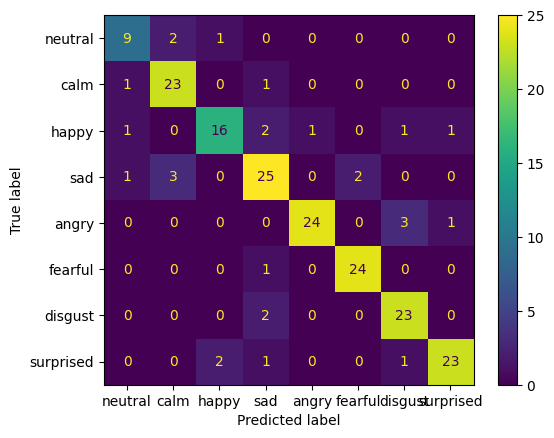

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=labels)
disp.plot()

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, "/content/drive/MyDrive/Speech_Emotion/whisper_small.pt")

In [ ]:
model=torch.load("/content/drive/MyDrive/Speech_Emotion/whisper_small.pt")